Данный блокнот был использован при участии [в соревновании на Kaggle](https://www.kaggle.com/competitions/29oct24hse-diamonds/overview). Главным условием соревнования было использование линейный моделей и метрики MAE.

Также вне соревнования были применены не линейные модели для улучшения качества метрики.

# Импортирование библиотек

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,RobustScaler
from sklearn.linear_model import LinearRegression, Ridge

# Подготовка данных

Dataset можно найти по [ссылке](https://www.kaggle.com/competitions/29oct24hse-diamonds/data)

In [ ]:
from google.colab import drive; drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/XY_diamonds.csv'

In [ ]:
df = pd.read_csv(path)

In [ ]:
df.head(10)

,carat,depth,table,x,y,z,cut,color,clarity,price
0,0.35,67.2,57.1,4.642,4.693,2.867,I,G,VS1,NaN
1,1.64,67.3,60.7,7.843,7.821,4.940,V,E,SI1,NaN
2,0.25,67.3,49.5,4.005,4.041,2.493,I,F,VVS1,NaN
3,0.28,67.9,60.3,4.299,4.258,2.661,P,E,VS2,NaN
4,0.34,67.5,69.4,5.439,5.497,3.321,P,E,VS2,NaN
5,1.27,69.4,68.4,8.330,8.283,5.387,F,G,SI2,NaN
6,0.62,67.8,47.6,4.872,4.906,2.993,I,F,VS2,NaN
7,1.02,66.0,51.2,5.774,5.730,3.638,V,F,SI2,NaN
8,0.67,64.4,54.2,4.677,4.579,2.856,F,G,SI1,NaN
9,0.34,67.8,54.7,4.354,4.393,2.656,I,F,VVS2,NaN


**Смысл колонок:**
1. price: The price of the Diamond
2. carat: The carat value of the Diamond
3. cut: The cut type of the Diamond, it determines the shine
4. color: The color value of the Diamond
5. clarity: The carat type of the Diamond
6. depth: The depth value of the Diamond
7. table: Flat facet on its surface — the large, flat surface
8. facet that you can see when you look at the diamond from above.
9. x: Width of the diamond
10. y: Length of the diamond
11. z: Height of the diamond


**Разделим данные на train и test**

In [ ]:
testX = df.query('price!=price').drop('price', axis=1)
trainXY = df.query('price==price')
trainX, trainY = trainXY.drop('price', axis=1), trainXY.price

In [ ]:
print("Test datasetX: ", testX.shape)
print("Train datasetX: ", testX.shape)

Test datasetX:  (40000, 9)
Train datasetX:  (40000, 9)


# EDA

In [ ]:
trainX.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160000 entries, 40000 to 199999
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   carat    160000 non-null  float64
 1   depth    160000 non-null  float64
 2   table    160000 non-null  float64
 3   x        160000 non-null  float64
 4   y        160000 non-null  float64
 5   z        160000 non-null  float64
 6   cut      160000 non-null  object 
 7   color    160000 non-null  object 
 8   clarity  160000 non-null  object 
dtypes: float64(6), object(3)
memory usage: 12.2+ MB


**Проверим данные на наличие пропусков**

In [ ]:
def missing_data(df):
    total = df.isnull().sum()
    percent = (df.isnull().sum()/df.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in df.columns:
        dtype = str(df[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(tt)

In [ ]:
print(missing_data(df))

         Total  Percent    Types
carat        0      0.0  float64
depth        0      0.0  float64
table        0      0.0  float64
x            0      0.0  float64
y            0      0.0  float64
z            0      0.0  float64
cut          0      0.0   object
color        0      0.0   object
clarity      0      0.0   object
price    40000     20.0  float64


**Проверим наличие дублей**

In [ ]:
duplicate_rows = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows.shape[0])

number of duplicate rows:  0


**Посмотрим статистики**

In [ ]:
trainX.describe().style.format("{:.2f}")

,carat,depth,table,x,y,z
count,160000.00,160000.00,160000.00,160000.00,160000.00,160000.00
mean,0.80,67.86,57.45,5.73,5.74,3.54
std,0.49,2.53,7.02,1.31,1.33,0.81
min,0.16,45.60,36.40,0.00,0.00,0.00
25%,0.39,65.90,51.60,4.73,4.74,2.92
50%,0.68,67.80,57.40,5.57,5.57,3.44
75%,1.07,69.80,63.10,6.63,6.62,4.09
max,5.76,86.60,96.10,11.79,65.41,8.95


In [ ]:
testX.describe().style.format("{:.2f}")

,carat,depth,table,x,y,z
count,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00
mean,0.80,67.88,57.49,5.74,5.75,3.55
std,0.49,2.54,7.01,1.31,1.33,0.83
min,0.17,48.20,40.90,0.00,0.00,0.00
25%,0.39,65.90,51.70,4.75,4.76,2.93
50%,0.69,67.80,57.40,5.58,5.58,3.44
75%,1.08,69.80,63.10,6.63,6.63,4.10
max,4.21,87.80,89.90,11.76,55.82,27.67


В переменных наблюдаем аномальные данные, так как длина, ширина и высота не может быть равна 0. Заменим их на медиану.

In [ ]:
for feature in ['x', 'y', 'z']:
    median_value = df[feature].median()
    trainX[feature] = trainX[feature].replace(0, median_value)
    testX[feature] = testX[feature].replace(0, median_value)

**Посмотрим на корреляцию числовых данных**

<Axes: >

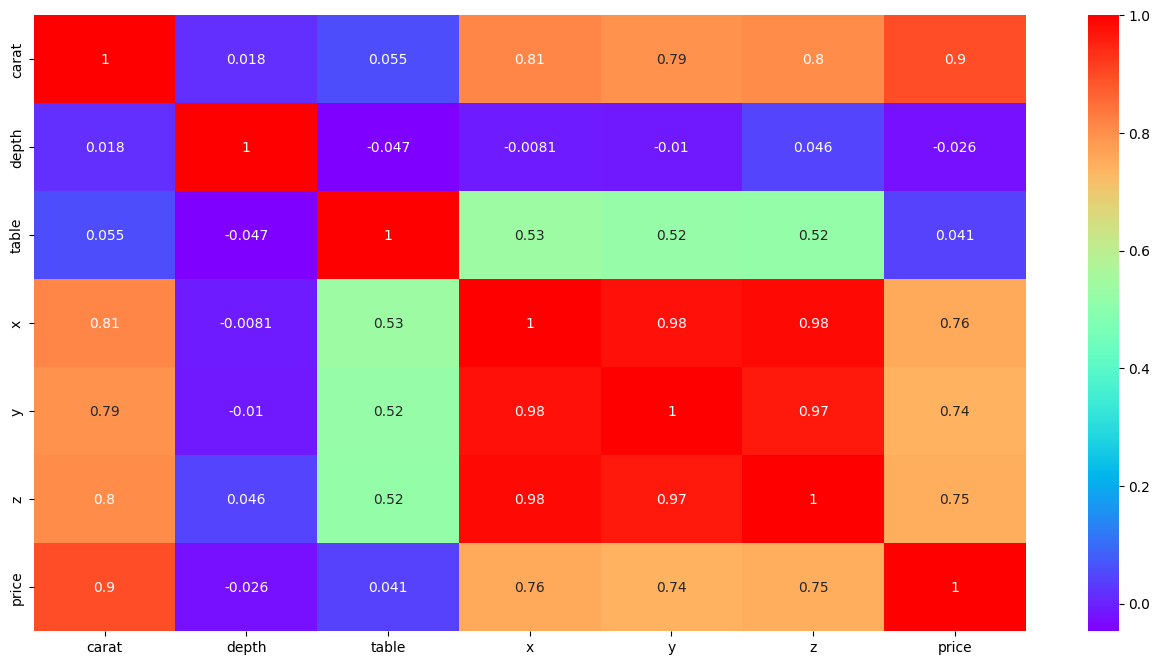

In [ ]:
corr = df[df.select_dtypes(include=['float64']).columns].corr()
plt.figure(figsize=(16,8))
sns.heatmap(corr,cmap='rainbow',annot=True)

Видно, что существуют сильно коррелированные столбцы, которые  в дальнейшем могут привести к мультиколлинеарности. Пока не будет убирать, но запомним это.

**Поработаем с выбросами**

<Axes: >

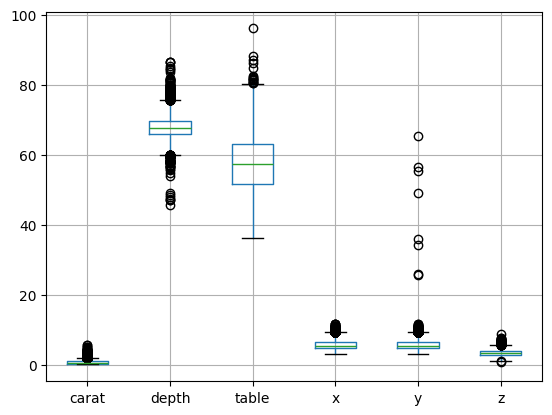

In [ ]:
trainX.boxplot()

<Axes: >

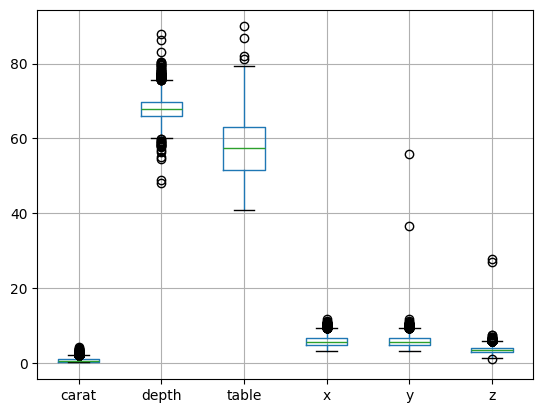

In [ ]:
testX.boxplot()

Как можно видеть в данных есть выбросы. Можно обрезать по квантилю, но лучше выберем в дальнейшем модель, которая предполагает выбросы (так лучше метрика)

In [ ]:
# def cut_by_quantile(df):
#   carat_max = df['carat'].quantile(0.95)
#   df.loc[df['carat'] > carat_max, "carat"] = carat_max

#   depth_max = df['depth'].quantile(0.95)
#   df.loc[df['depth'] > depth_max, "depth"] = depth_max

#   depth_min= df['depth'].quantile(0.05)
#   df.loc[df['depth'] < depth_min, "depth"] = depth_min

#   table_max = df['table'].quantile(0.95)
#   df.loc[df['table'] > table_max, "table"] = table_max
#   x_max = df['x'].quantile(0.95)
#   df.loc[df['x'] > x_max, "x"] = x_max

#   x_min= df['x'].quantile(0.05)
#   df.loc[df['x'] < x_min, "x"] = x_min

#   y_max = df['y'].quantile(0.95)
#   df.loc[df['y'] > y_max, "y"] = y_max

#   y_min= df['y'].quantile(0.05)
#   df.loc[df['y'] < y_min, "y"] = y_min

#   z_max = df['z'].quantile(0.95)
#   df.loc[df['z'] > z_max, "z"] = z_max

#   z_min= df['z'].quantile(0.05)
#   df.loc[df['z'] < z_min, "z"] = z_min
#   return df

In [ ]:
# trainX = cut_by_quantile(trainX)
# testX = cut_by_quantile(testX)

**Посмотрим распределения**

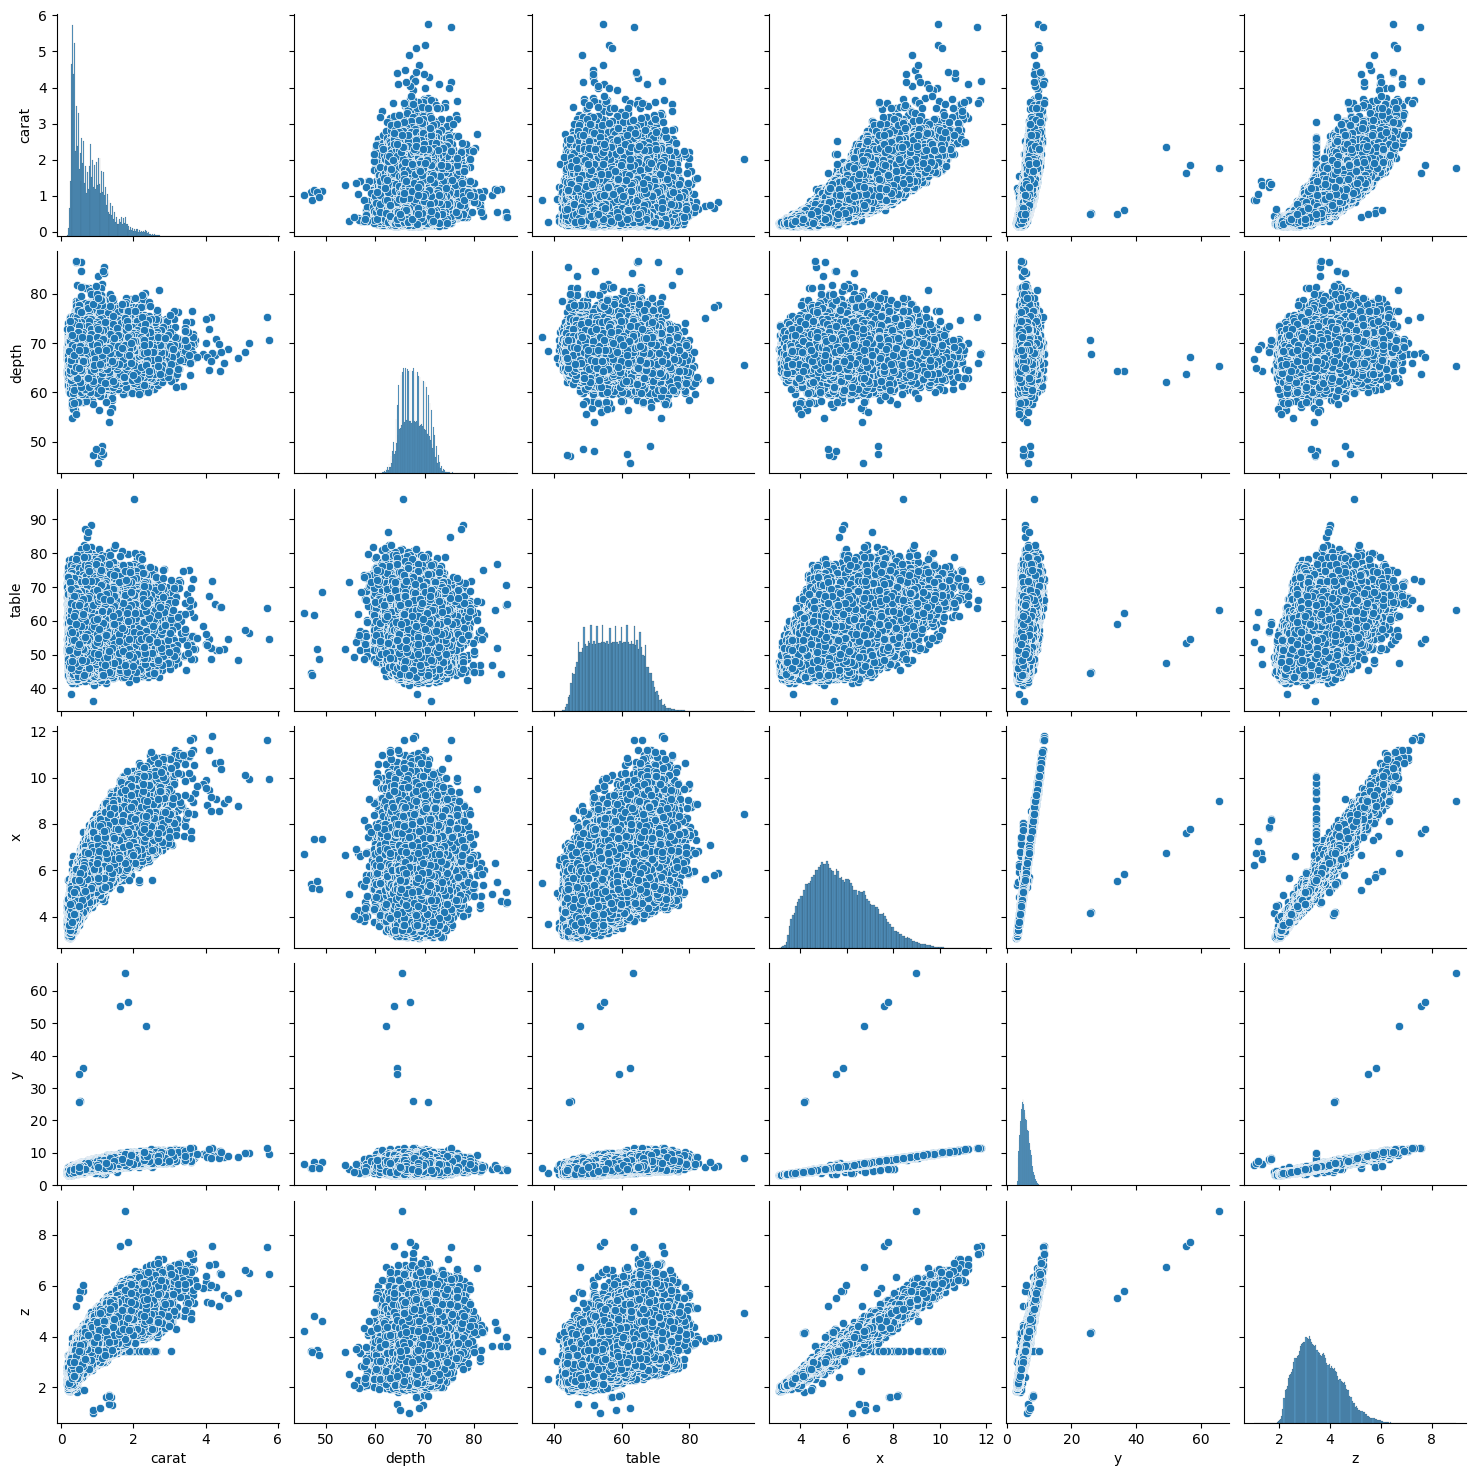

In [ ]:
sns.pairplot(trainX[trainX.select_dtypes(include=['float64']).columns])

Видим, что некоторые категории имеют ассиметрию. Их можно преобразовать. Однако это ухудшило качество метрики, поэтому пропустим это.

In [ ]:
# for col in trainX[trainX.select_dtypes(include=['float64']).columns]:
#   skewness = df[col].skew()
#   print(col, skewness)

In [ ]:
# def log_to_normal(df):
#   for feature in ['carat', 'x', 'y', 'z']:
#     df[feature] = np.log(df[feature])
#   return df

In [ ]:
# trainX = log_to_normal(trainX)
# testX = log_to_normal(testX)

**Три переменных с категориальными данными(cut, color, clarity), которые необходимо обработать**

In [ ]:
def ohe_cat(df):
  df = pd.get_dummies(df, columns=['color'], drop_first=True)*1
  df = pd.get_dummies(df, columns=['clarity'], drop_first=True)*1
  df = pd.get_dummies(df, columns=['cut'], drop_first=True)*1
  return df

In [ ]:
trainX = ohe_cat(trainX)
testX = ohe_cat(testX)

**Добавим синтетических данных, которые позволят модели лучше обучиться**

In [ ]:
def add_features(df):
    df['volume'] = df['x'] * df['y'] * df['z']
    df['volume_per_carat'] = df['volume'] / df['carat']
    df['width_to_length_ratio'] = df['x'] / df['y']
    df['table_to_depth_ratio'] = df['table'] / df['depth']
    df['carat_squared'] = df['carat'] ** 2
    df['carat_table'] = df['carat'] * df['table']
    return df

In [ ]:
trainX = add_features(trainX)
testX = add_features(testX)

**Проверим целувую переменную**

In [ ]:
df.describe()

,carat,depth,table,x,y,z,price
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,160000.000000
mean,0.799664,67.863993,57.461051,5.735894,5.739521,3.541322,4487.567206
std,0.486402,2.531133,7.016496,1.308694,1.332748,0.814069,4749.936778
min,0.160000,45.600000,36.400000,0.000000,0.000000,0.000000,329.000000
25%,0.390000,65.900000,51.600000,4.732750,4.741000,2.921000,987.750000
50%,0.680000,67.800000,57.400000,5.572000,5.575000,3.440000,2574.000000
75%,1.070000,69.800000,63.100000,6.629000,6.625000,4.094000,6160.250000
max,5.760000,87.800000,96.100000,11.788000,65.411000,27.672000,23566.000000


(array([81464., 26453., 20047., 10457.,  6698.,  4889.,  3651.,  2922.,
         2456.,   963.]),
 array([  329. ,  2652.7,  4976.4,  7300.1,  9623.8, 11947.5, 14271.2,
        16594.9, 18918.6, 21242.3, 23566. ]),
 <BarContainer object of 10 artists>)

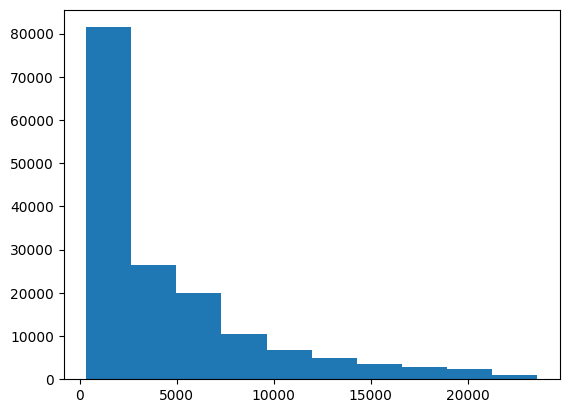

In [ ]:
plt.hist(trainY.to_frame()['price'])

<Axes: xlabel='price', ylabel='Density'>

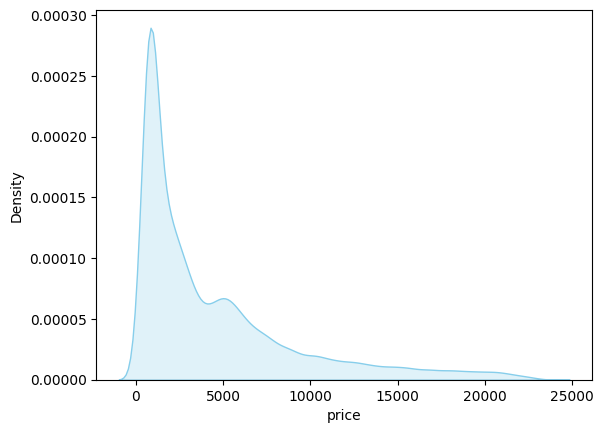

In [ ]:
sns.kdeplot(data=trainY.to_frame()['price'], fill=True, color='skyblue', label=f"Density of price")

In [ ]:
trainY.to_frame()['price'].skew()

1.6558026375899277

Как видно, целевая переменная имеет ассиметрию. Её можно привести к нормальному распределению с помощью логарифма. Однако это ухудшило качество метрики, поэтому пропустим это.

In [ ]:
# trainY = np.log(trainY)

In [ ]:
trainY.skew()

1.6558026375899277

<Axes: xlabel='price', ylabel='Density'>

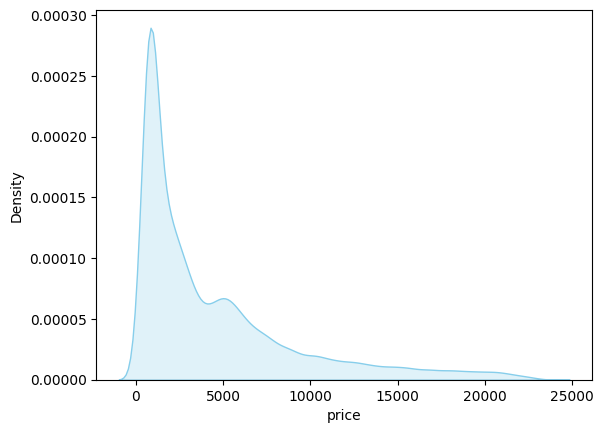

In [ ]:
sns.kdeplot(data=trainY.to_frame()['price'], fill=True, color='skyblue', label=f"Density of price")

# Baseline линейной модели

Разделим на train set и validation set.
Данные обучения trainX делим на trainX_ и valX, и соответсвенно для trainY.

In [ ]:
trainX_, valX, trainY_, valY = train_test_split(trainX, trainY, test_size=0.2, random_state=42, shuffle = True)

In [ ]:
trainX.shape, valX.shape

((160000, 29), (32000, 29))

In [ ]:
trainX_.shape, valX.shape

((128000, 29), (32000, 29))

In [ ]:
base_pipline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('model', LinearRegression())
])

In [ ]:
base_pipline.fit(trainX_, trainY_)
train_pred = base_pipline.predict(trainX_)
val_pred = base_pipline.predict(valX)


# Вычисление MAE на валидационной выборке
mae = mean_absolute_error(valY, val_pred)
print(f"Mean Absolute Error (MAE) на валидационной выборке: {mae:.2f}")

# Вычисление MAE на обучающей выборке
mae_train = mean_absolute_error(trainY_, train_pred)
print(f"Mean Absolute Error (MAE) на обучающей выборке: {mae_train:.2f}")

Mean Absolute Error (MAE) на валидационной выборке: 663.62
Mean Absolute Error (MAE) на обучающей выборке: 657.62


# Улучшение линейной модели

In [ ]:
p1 = Pipeline([
    ('scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('model', Ridge())
])

In [ ]:
mae_scorer = cross_val_score(p1, trainX, trainY, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
print("Среднее MAE: ", -mae_scorer)

Среднее MAE:  670.2001188158102


**Давайте найдём наилучшие параметры, используя Optuna для быстрого вычисления**

In [ ]:
prep = Pipeline([
    ('scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)) #3
])

In [ ]:
trainX_ = prep.fit_transform(trainX_)
trainX = prep.transform(trainX)
valX = prep.transform(valX)

Давайте найдём параметры для модели, на которых получится лучше метрика

In [ ]:
pip install optuna -q

In [ ]:
import optuna

In [ ]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.001, 10.0, log=True) # log scale

    score = cross_val_score(Ridge(alpha = alpha), trainX, trainY, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
    return - score

# 3. Create study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2025-01-15 14:46:50,177] A new study created in memory with name: no-name-6c676007-e3aa-45a9-bf7d-a7bc7423eca2
[I 2025-01-15 14:46:57,086] Trial 0 finished with value: 672.307806953203 and parameters: {'alpha': 0.05469787700562402}. Best is trial 0 with value: 672.307806953203.
[I 2025-01-15 14:47:03,642] Trial 1 finished with value: 672.828615495675 and parameters: {'alpha': 0.009083188629258077}. Best is trial 0 with value: 672.307806953203.
[I 2025-01-15 14:47:09,599] Trial 2 finished with value: 670.69377842896 and parameters: {'alpha': 0.6610412402706163}. Best is trial 2 with value: 670.69377842896.
[I 2025-01-15 14:47:17,238] Trial 3 finished with value: 672.6537434881913 and parameters: {'alpha': 0.028131684481458103}. Best is trial 2 with value: 670.69377842896.
[I 2025-01-15 14:47:23,136] Trial 4 finished with value: 671.9426850417506 and parameters: {'alpha': 0.10574975791014529}. Best is trial 2 with value: 670.69377842896.
[I 2025-01-15 14:47:30,316] Trial 5 finished wi

In [ ]:
print(f"Best params: {study.best_params}")
print(f"Best MAE: {study.best_value:.3f}")

Best params: {'alpha': 4.875030882750515}
Best MAE: 668.386


In [ ]:
model = Ridge(**study.best_params)
model.fit(trainX_, trainY_)
train_pred = model.predict(trainX_)
val_pred = model.predict(valX)


# Вычисление MAE на валидационной выборке
mae = mean_absolute_error(valY, val_pred)
print(f"Mean Absolute Error (MAE) на валидационной выборке: {mae:.2f}")

# Вычисление MAE на обучающей выборке
mae_train = mean_absolute_error(trainY_, train_pred)
print(f"Mean Absolute Error (MAE) на обучающей выборке: {mae_train:.2f}")

Mean Absolute Error (MAE) на валидационной выборке: 669.07
Mean Absolute Error (MAE) на обучающей выборке: 663.85


In [ ]:
mae_scorer = cross_val_score(Ridge(**study.best_params), trainX, trainY, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
print("Среднее MAE: ", -mae_scorer)

Среднее MAE:  668.386417397872


# Используем не линейные модели

In [ ]:
!pip install lightgbm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.5 MB/s eta 0:00:00


In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
lgbm = LGBMRegressor()

mae_scorer = cross_val_score(lgbm, trainX, trainY, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
print("Среднее MAE: ", -mae_scorer)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Среднее MAE:  606.8868305550333


# Улучшаем не линейную модель

In [ ]:
def objective(trial):
    lgb_params = {
        'objective': 'regression',
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 30, 100),
        'max_depth': trial.suggest_int('max_depth', -1, 10),
    }
    score = cross_val_score(LGBMRegressor(**lgb_params), trainX, trainY, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
    return - score


# 3. Create a study
study = optuna.create_study(direction="minimize")

# 4. Run optimization
study.optimize(objective, n_trials=10)

# 5. Get best parameters
print(f"Best params: {study.best_params}")
print(f"Best MAE: {study.best_value}")

[I 2025-01-15 17:25:07,561] A new study created in memory with name: no-name-ed86309a-d401-48ba-9be1-b39db8180330
[I 2025-01-15 17:26:39,802] Trial 0 finished with value: 630.4991379931381 and parameters: {'n_estimators': 326, 'learning_rate': 0.03252943548854144, 'num_leaves': 63, 'max_depth': 6}. Best is trial 0 with value: 630.4991379931381.
[I 2025-01-15 17:27:33,944] Trial 1 finished with value: 664.2692723299683 and parameters: {'n_estimators': 293, 'learning_rate': 0.06253940147876356, 'num_leaves': 76, 'max_depth': 4}. Best is trial 0 with value: 630.4991379931381.
[I 2025-01-15 17:29:00,530] Trial 2 finished with value: 697.9674597063744 and parameters: {'n_estimators': 186, 'learning_rate': 0.022733963161759185, 'num_leaves': 83, 'max_depth': 7}. Best is trial 0 with value: 630.4991379931381.
[I 2025-01-15 17:29:23,973] Trial 3 finished with value: 1319.292313797113 and parameters: {'n_estimators': 133, 'learning_rate': 0.026885331487116644, 'num_leaves': 73, 'max_depth': 1}.

Best params: {'n_estimators': 171, 'learning_rate': 0.06247779455620543, 'num_leaves': 99, 'max_depth': 10}
Best MAE: 559.1208782644665


In [ ]:
print(f"Best params: {study.best_params}")
print(f"Best MAE: {study.best_value}")

Best params: {'n_estimators': 171, 'learning_rate': 0.06247779455620543, 'num_leaves': 99, 'max_depth': 10}
Best MAE: 559.1208782644665


In [ ]:
lgbm = LGBMRegressor(**study.best_params)

mae_scorer = cross_val_score(lgbm, trainX, trainY, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
print("Среднее MAE: ", -mae_scorer)

Среднее MAE:  553.9411785194206


# Предсказываем на тесте

Итоговый Pipline выглядит так, но так как мы уже выполнили преобразования для train выборки (для использования его в cross-validation), будет использовать его как просто демонстрацию и преобразуем тестовые данные отдельно

In [ ]:
final_pipline = Pipeline([
    ('scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('model', LGBMRegressor(**study.best_params))
])

In [ ]:
testX = prep.transform(testX)

In [ ]:
final_model =  LGBMRegressor(**study.best_params)
final_model.fit(trainX, trainY)
y_pred = final_model.predict(testX)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.258225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72588
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 422
[LightGBM] [Info] Start training from score 4487.567206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
y_pred

array([  732.91271867, 14166.88226908,   927.40182569, ...,
         706.14497229,  1307.08548217,  7823.94414958])

In [ ]:
pY = pd.DataFrame(y_pred, index=range(1,len(testX)+1), columns=['price'])  # ensure that labels and observations are in corresponding order
pY = pY.clip(lower=10)  # ensures no negative prices

In [ ]:
pY

,price
1,732.912719
2,14166.882269
3,927.401826
4,809.589507
5,886.959293
...,...
39996,6127.938548
39997,5011.395550
39998,706.144972
39999,1307.085482


In [ ]:
pY.to_csv('DA.csv', index=True)